Hidden Markov 

In [40]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gym

In [41]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Quy trình quyết định Markov**

Hãy xác định một số xác suất chuyển đổi, điểm thưởng và các hành động có thể. Ví dụ: ở trạng thái s0, nếu hành động a0 được chọn thì với xác suất 0.7 ta sẽ chuyển sang trạng thái s0 với điểm thưởng +10, với xác suất 0.3 ta sẽ chuyển sang trạng thái s1 không có điểm thưởng và không bao giờ chuyển sang trạng thái s2 (vì vậy xác suất chuyển tiếp là [0.7, 0.3, 0.0] và điểm thưởng là [+10, 0, 0]):

In [42]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Lặp lại giá trị Q

In [43]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [44]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [45]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [46]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

Chính sách tối ưu cho MDP này, khi sử dụng hệ số chiết khấu là 0.90, là chọn hành động a0 khi ở trạng thái s0, và chọn hành động a0 khi ở trạng thái s1, và cuối cùng chọn hành động a1 (hành động khả thi duy nhất) khi ở trạng thái s2.
So sánh với hệ số chiết khấu gamma = 0.95

In [47]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [48]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [49]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [50]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

Bây giờ chính sách đã thay đổi! Ở trạng thái s1, bây giờ ta thích đi qua lửa hơn (chọn hành động a2). Điều này là do hệ số chiết khấu lớn hơn nên tác nhân coi trọng tương lai hơn và do đó sẵn sàng trả tiền phạt ngay lập tức để nhận được nhiều điểm thưởng hơn trong tương lai.

# **Q-Learning**

Q-Learning hoạt động bằng cách xem tác nhân chơi (ví dụ: một cách ngẫu nhiên) và dần dần cải thiện các ước tính của tác nhân đó về Giá trị Q. Khi nó có các ước tính Giá trị Q chính xác (hoặc gần đủ chính xác), thì chính sách tối ưu bao gồm việc chọn hành động có Giá trị Q cao nhất (tức là chính sách tham lam).

Ta sẽ cần mô phỏng một tác nhân di chuyển xung quanh trong môi trường, vì vậy, hãy viết một hàm để thực hiện một số hành động và nhận trạng thái mới cũng như điểm thưởng:

In [51]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Ta cũng cần một chính sách thăm dò, có thể là bất kỳ chính sách nào, miễn là nó khảo sát mọi trạng thái có thể nhiều lần. Ta chỉ sử dụng một chính sách ngẫu nhiên, vì không gian trạng thái rất nhỏ:

In [52]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Bây giờ, hãy khởi tạo Giá trị Q như trước đó và chạy thuật toán Q-Learning:

In [53]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [54]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [55]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

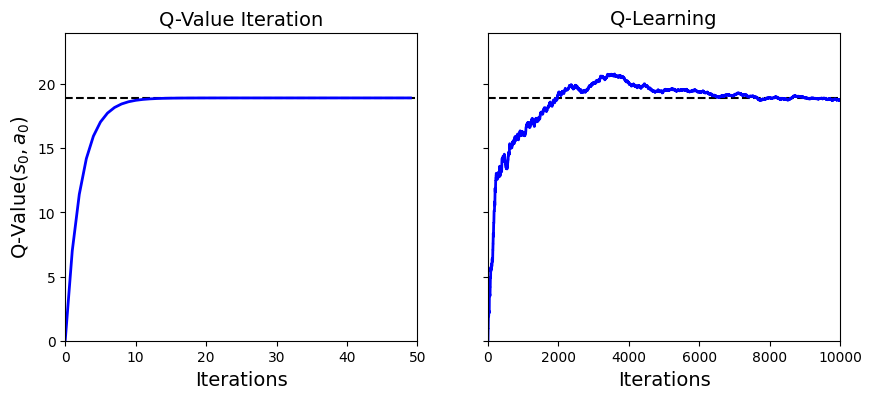

In [56]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

plt.savefig("q_value_plot")

**Deep Q-Learning (DQN)**
Với một trạng thái, nó sẽ ước tính, cho mỗi hành động có thể xảy ra, tổng số điểm thưởng được chiết khấu trong tương lai mà nó có thể mong đợi sau khi thực hiện hành động đó (nhưng trước khi nó nhìn thấy kết quả của nó):

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Để chọn một hành động sử dụng DQN này, ta chỉ chọn hành động có giá trị Q dự đoán lớn nhất. Tuy nhiên, để đảm bảo rằng tác nhân khám phá môi trường, ta chọn một hành động ngẫu nhiên có xác suất epsilon.

In [58]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ta cũng sẽ cần một bộ nhớ phát lại. Nó sẽ chứa các trải nghiệm của tác nhân, ở dạng tuple: (obs, action, bonus, next_obs, done). Ta có thể sử dụng lớp deque cho việc đó (nhưng hãy nhớ xem thư viện Reverb tuyệt vời của DeepMind để triển khai phát lại trải nghiệm mạnh mẽ hơn nhiều):

In [59]:
from collections import deque

replay_memory = deque(maxlen=2000)

Và hãy tạo một chức năng để lấy mẫu trải nghiệm từ bộ nhớ phát lại. Nó sẽ trả về 5 mảng NumPy: [obs, actions, Rewards, next_obs, dones].

In [60]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Tạo một hàm sử dụng DQN để phát một bước và ghi lại trải nghiệm của nó trong bộ nhớ phát lại:

In [61]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Cuối cùng, hãy tạo một hàm lấy mẫu một số trải nghiệm từ bộ nhớ phát lại và thực hiện một bước huấn luyện:

Ghi chú:

3 bản phát hành đầu tiên của ấn bản thứ 2 thiếu thao tác reshape() giúp chuyển đổi target_Q_values thành một vector cột (điều này được yêu cầu bởi loss_fn()).
Cuốn sách sử dụng tốc độ học là 1e-3, nhưng trong mã bên dưới tôi sử dụng 1e-2, vì nó cải thiện đáng kể việc huấn luyện. Chúng tôi cũng đã điều chỉnh tốc độ học của các biến thể DQN bên dưới.

In [62]:
import keras

In [63]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Huấn luyện mô hình

In [64]:
import tensorflow as tf
import gym
env = gym.make('CartPole-v1')


In [65]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [66]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


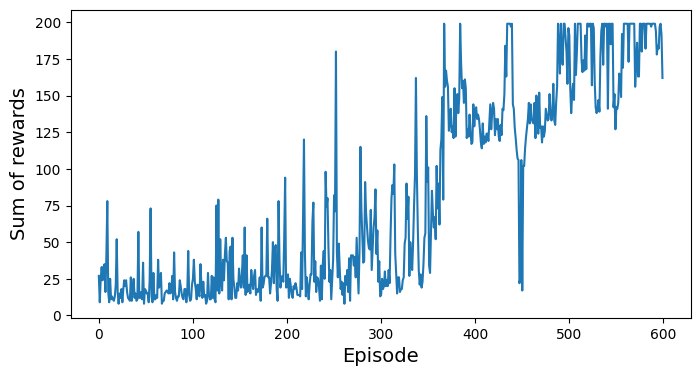

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.savefig("dqn_rewards_plot")
plt.show()

In [69]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

1/1 [==============================] - 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 39ms/step


NameError: ignored

**Double DQN**
Double DQNs, or Double Deep Q-Learning neural networks, were introduced by Hado van Hasselt. This method handles the problem of the overestimation of Q-values.
The solution is: when we compute the Q target, we use two networks to decouple the action selection from the target Q-value generation. We:
- Use our DQN network to select the best action to take for the next state (the action with the highest Q-value).
- Use our Target network to calculate the target Q-value of taking that action at the next state.

Therefore, Double DQN helps us reduce the overestimation of Q-values and, as a consequence, helps us train faster and with more stable learning.


In [70]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [71]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [72]:
replay_memory = deque(maxlen=2000)

In [73]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [ ]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   
plot_animation(frames)

**Dueling DQN**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [ ]:
env.close()